# Time Evolution with HAP-hd

In [111]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from gammapy.detect import compute_lima_on_off_image,compute_lima_image # quelle différence entre les deux ?
from gammapy.data import DataStore
from gammapy.irf import make_mean_psf
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.cube import (
    MapDatasetMaker,
    PSFKernel,
    MapDataset,
    RingBackgroundMaker,
    SafeMaskMaker,
    #RingBackgroundEstimator,
)
from gammapy.modeling.models import (
    SkyModel,
    SkyModels,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    SkyDiffuseCube,
    TemplateSpatialModel,
    GaussianSpatialModel
)
from gammapy.stats import significance, excess # utiles ?

from gammapy.modeling import Fit
from astropy.time import Time

src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

import gammapy
gammapy.__version__

'0.15'

In [112]:
emin, emax = [0.5, 100] * u.TeV

energy_axis = MapAxis.from_bounds(
    emin.value, emax.value, 20, unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

geom2d = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
)

energy_axis_true = MapAxis.from_bounds(
    0.3, 200, 30, unit="TeV", name="energy", interp="log"
)

In [113]:
from pathlib import Path

# Directory for outputs

path = Path("../../../../gammapy_data/GC_variability2020_full/hap-hd")
path.mkdir(exist_ok=True)

## Creating the datasets

In [114]:
mapdataset_dict = {}

for k in range (2004,2020):
    name = "map" + str(k)
    mapdataset_dict[k] = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name=name)

for year in range(2004,2020):
    
    filename = "mapdatasets/mapdataset" +str(year)+".fits.gz"
    mapdataset_dict[year] = MapDataset.read(path/filename)

## Reading the model template

In [115]:
pathmo = Path("../../../../gammapy_data/GC_variability2020_full/hap-hd/models")
pathmo.mkdir(exist_ok=True)

name = pathmo/"models_template.yaml"
modelGC,modelG09, modeldiff = SkyModels.read(name)

## Constructing the mask

In [116]:
fit_region = RectangleSkyRegion(src_pos, 4*u.deg, 2*u.deg)

bizarre_region = CircleSkyRegion(SkyCoord(358.6,  -0.6, unit="deg", frame="galactic"), 0.5 * u.deg)

fit_mask = geom.region_mask([fit_region])*geom.region_mask([bizarre_region] , inside=False)

fit_mask = Map.from_geom(geom, data=fit_mask)

## Applying the mask and the model template

In [117]:
for year in range(2004,2020):
    mapdataset_dict[year].fit_mask = fit_mask
    mapdataset_dict[year].models =  modelGC.copy() + modelG09.copy() +  modeldiff.copy()
    mapdataset_dict[year].background_model.parameters['norm'].value = 1.0

# Fitting the datasets

In [118]:
def fit_dataset(mapdataset):
    fit = Fit([mapdataset])
    result = fit.run()
    
    table = result.parameters.to_table()
    
    rescov = fit.covariance()
    ampSGRA = mapdataset.models.parameters[3]
    ampdiff = mapdataset.models.parameters[12]
    normbkg = mapdataset.background_model.parameters['norm']
    
    cov= rescov.parameters.get_subcovariance([ampSGRA, ampdiff, normbkg])
    
    return table, cov, result

In [119]:
%%time

results_per_year = dict()
results = []
cov_per_year = dict()


for year in range(2004,2020):
    
    table, cov, result = fit_dataset(mapdataset_dict[year])
    
    results.append(result)
    
    results_per_year[year] = table
    
    cov_per_year[year] = cov
    

CPU times: user 13min 28s, sys: 25 s, total: 13min 53s
Wall time: 13min 53s


In [120]:
years = []
for year in range(2004,2020):
    if results[year-2004].message =='Optimization terminated successfully.':
        years.append(year)

In [98]:
#years.remove(2017)

# Saving the results

## Model predictions

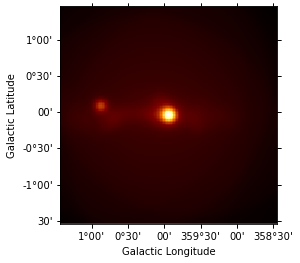

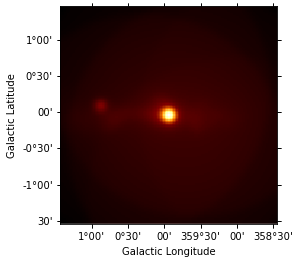

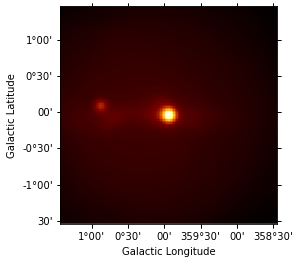

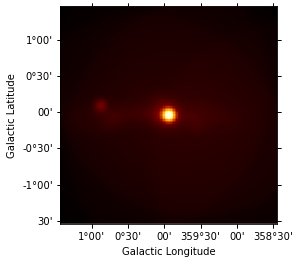

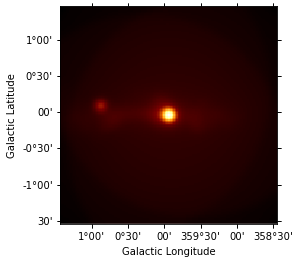

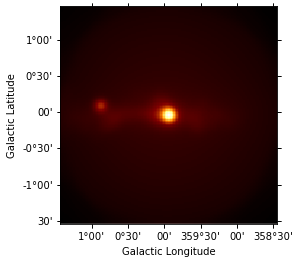

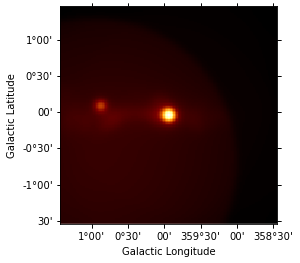

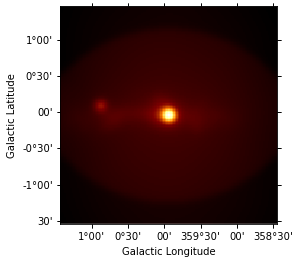

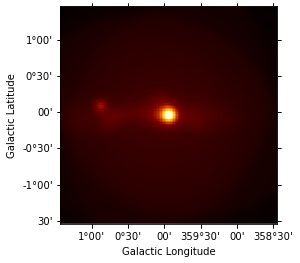

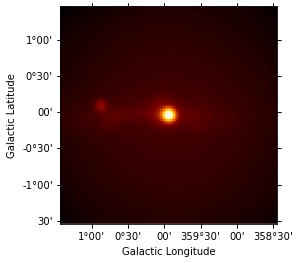

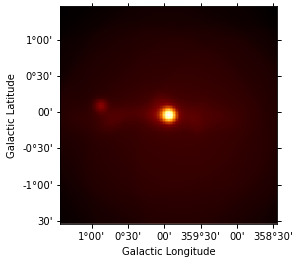

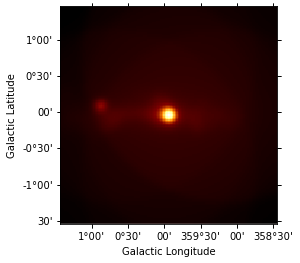

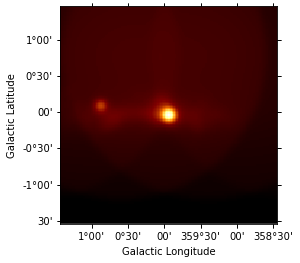

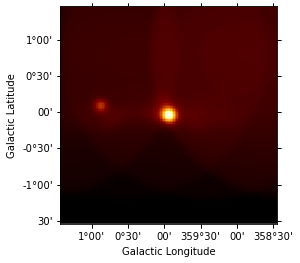

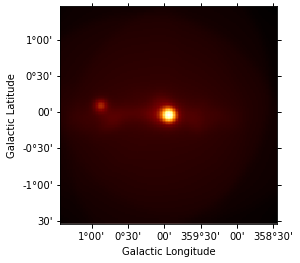

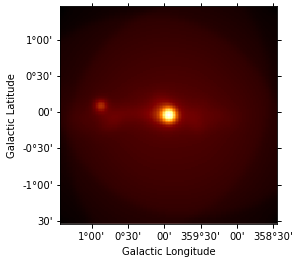

In [121]:
pathm = Path(path/"models/maps")
pathm.mkdir(exist_ok=True)

for year in years:
    plt.figure()
    mapdataset_dict[year].npred().sum_over_axes().cutout(src_pos,3*u.deg).smooth('0.05 deg').plot()
    name ="model_"+ str(year)+"_map_hd_full.pdf"
    plt.savefig(pathm/name)

## Residuals

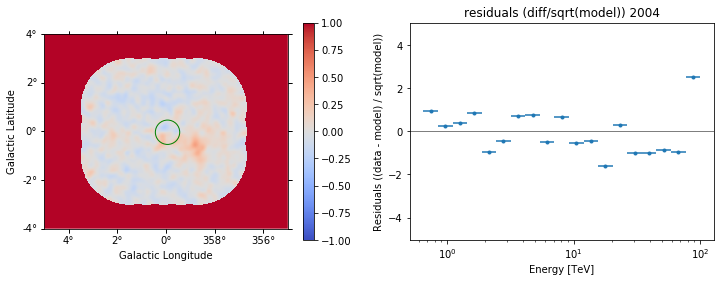

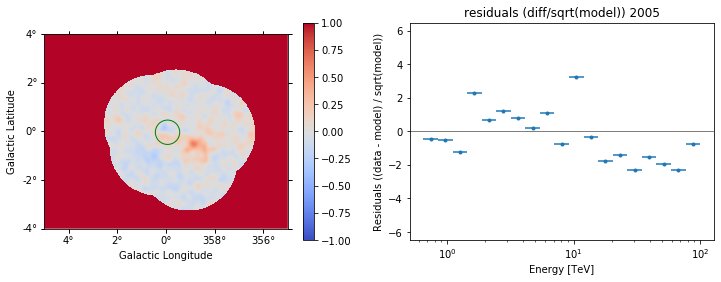

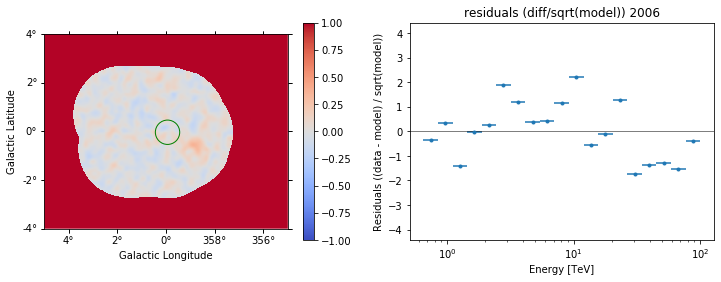

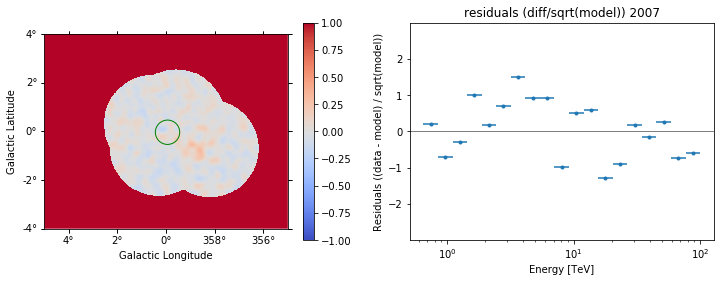

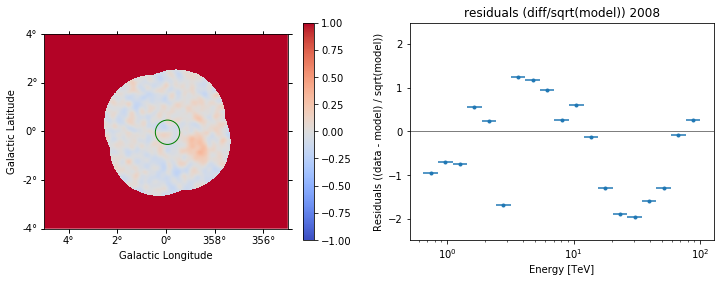

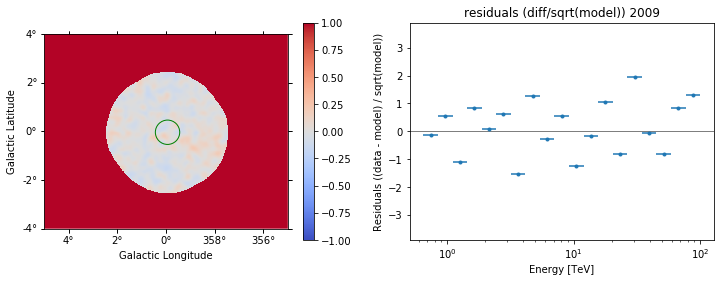

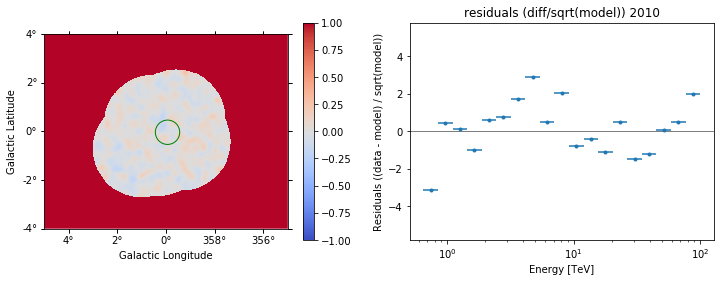

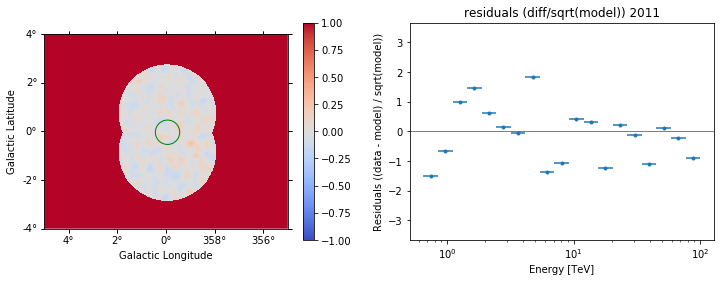

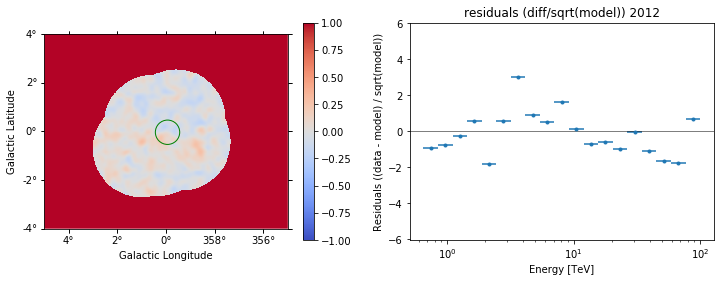

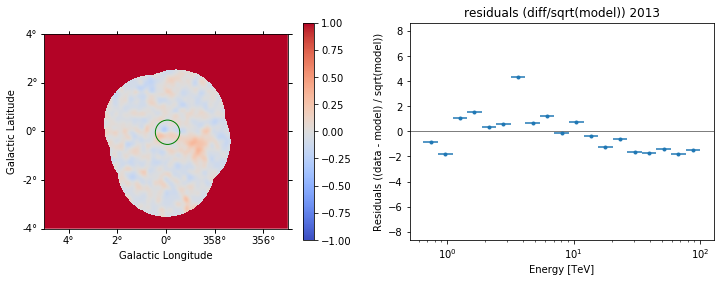

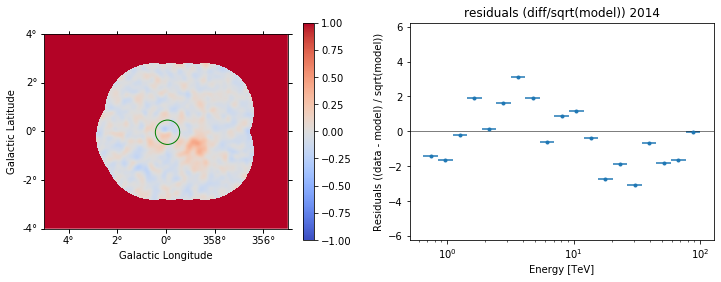

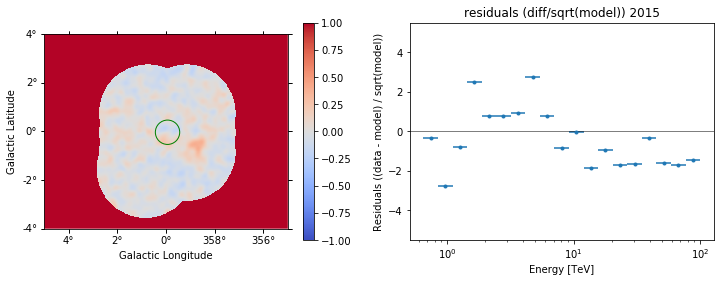

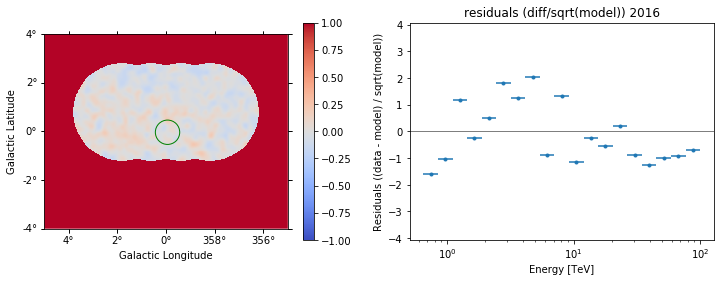

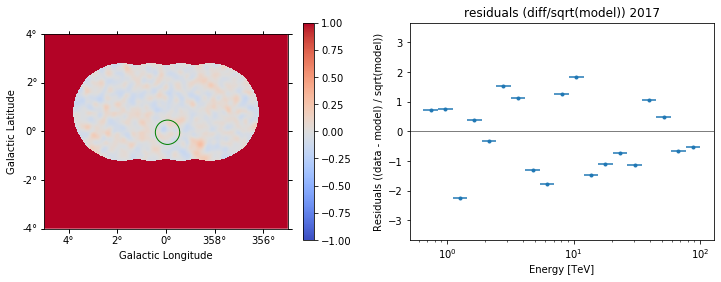

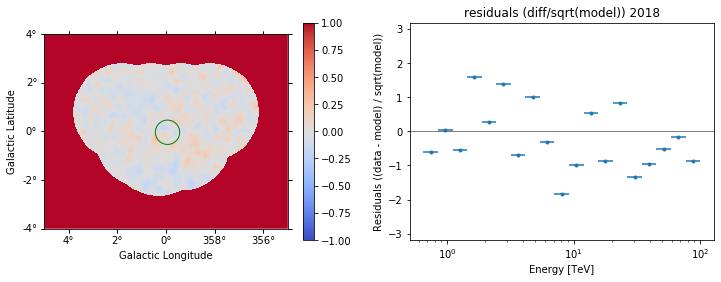

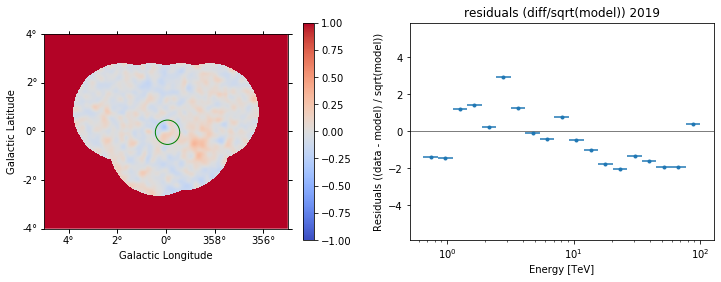

In [122]:
pathr = Path(path/"residuals")
pathr.mkdir(exist_ok=True)

region = CircleSkyRegion(
    center=src_pos, radius=0.5 * u.deg
)

for year in years:
    mapdataset_dict[year].plot_residuals(
        region=region, method="diff/sqrt(model)", vmin=-1.0, vmax=1.0
        )
    name = "residuals_"+str(year)+"_hd_full.pdf"
    plt.title("residuals (diff/sqrt(model)) " + str(year))
    plt.savefig(pathr/name, overwrite=True)

## Significance

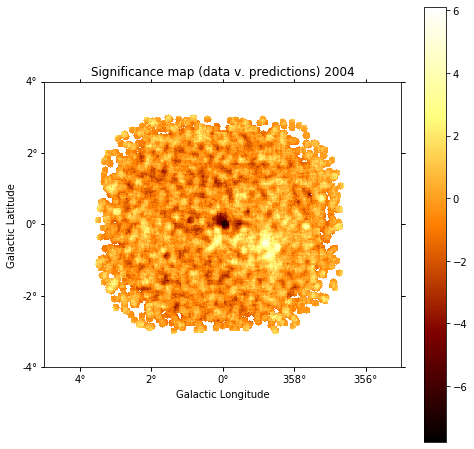

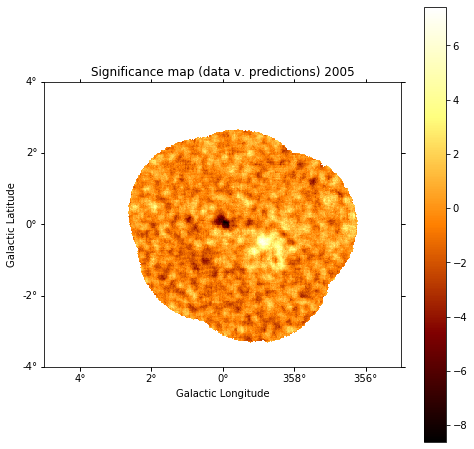

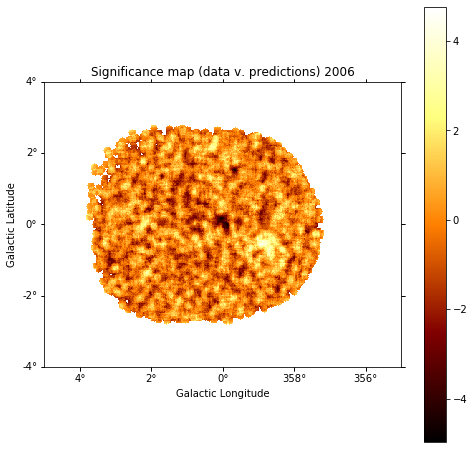

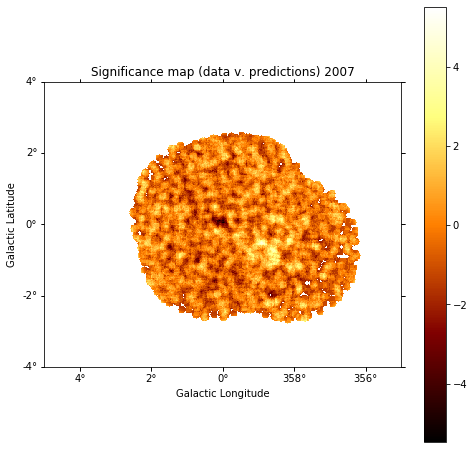

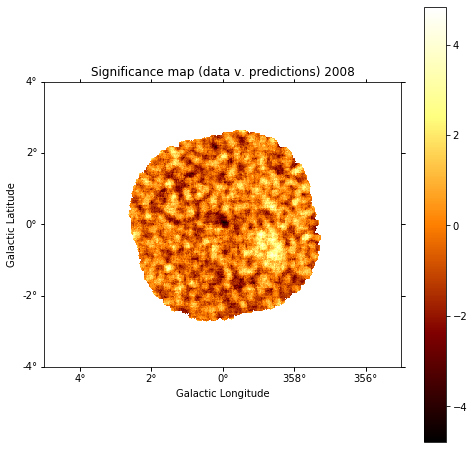

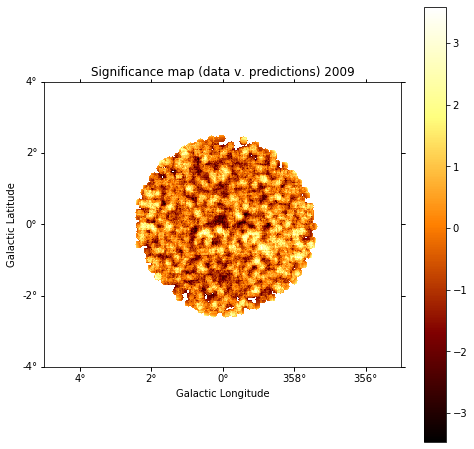

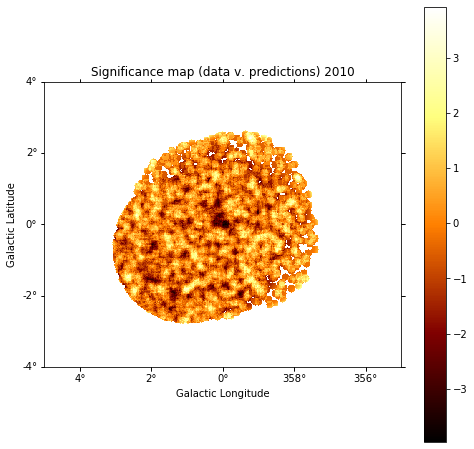

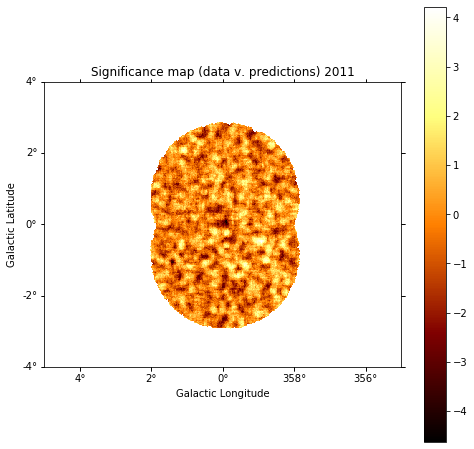

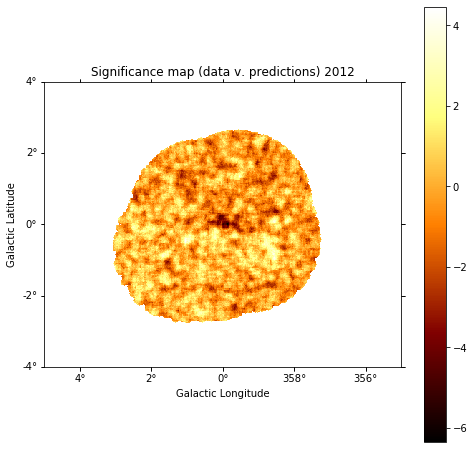

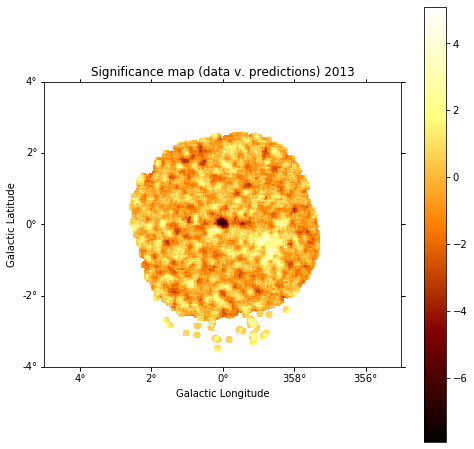

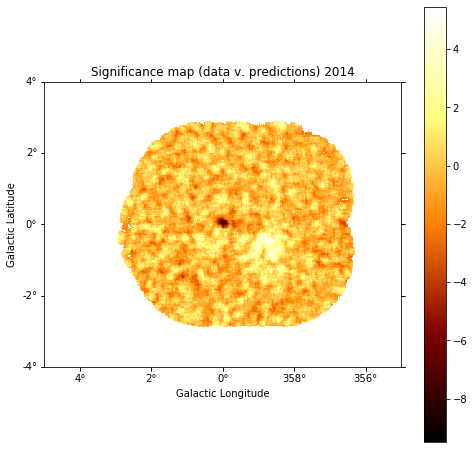

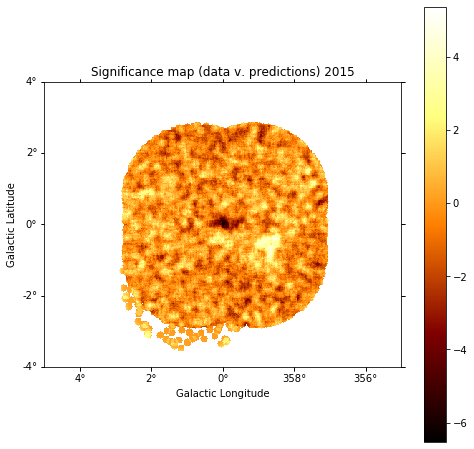

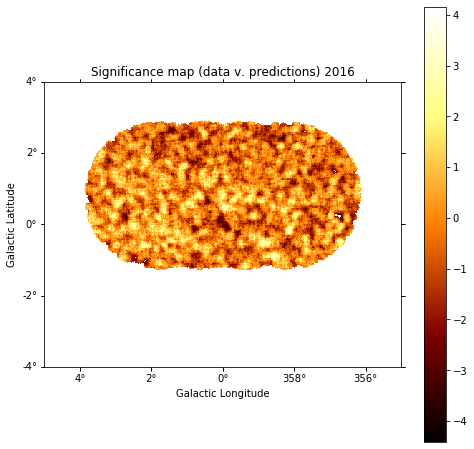

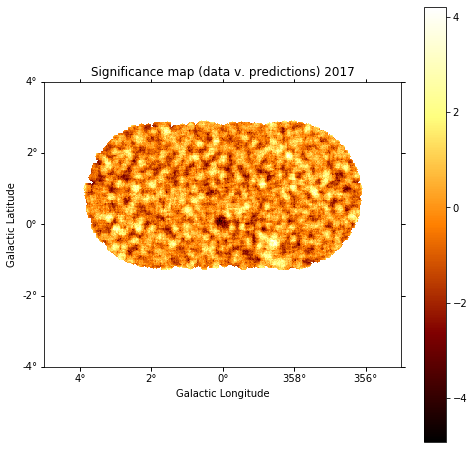

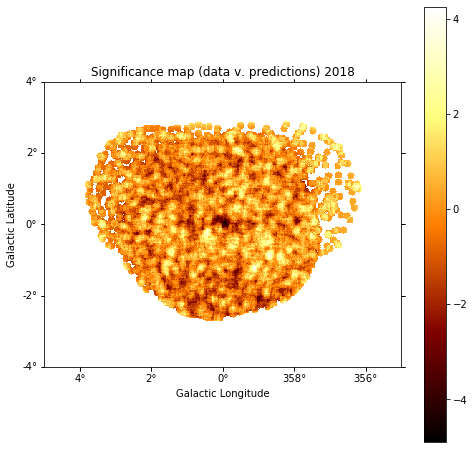

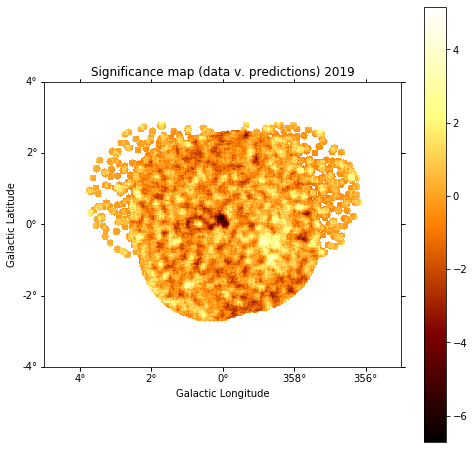

In [123]:
paths = Path(path/"significance")
paths.mkdir(exist_ok=True)

kernel = Tophat2DKernel(5) # il faut élargir la région où l'on compte les coups pour calculer la significativité, ici on prend 5 bin en distance angulaire par ex

lima_significances = dict()

for year in years:
    plt.figure(figsize=(8,8))
    counts = mapdataset_dict[year].counts.sum_over_axes()
    mod = mapdataset_dict[year].npred().sum_over_axes()
    lima_significances[year] = compute_lima_image(counts, mod, kernel)
    
    lima_significances[year]['significance'].plot(add_cbar=True)
    name = "significance_"+str(year)+"_hd_full.pdf"
    plt.title("Significance map (data v. predictions) "+str(year))
    plt.savefig(paths/name, overwrite=True)

/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)


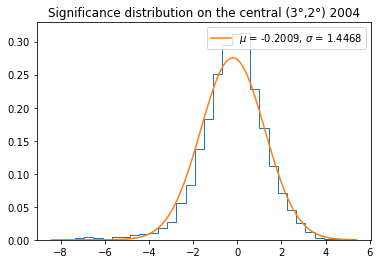

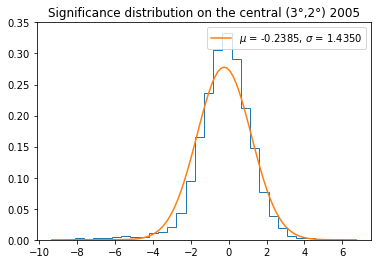

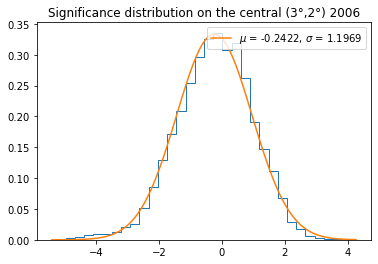

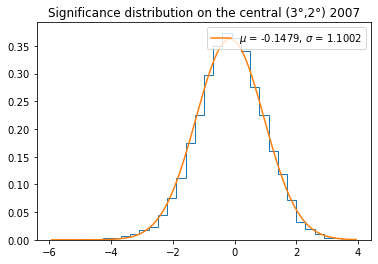

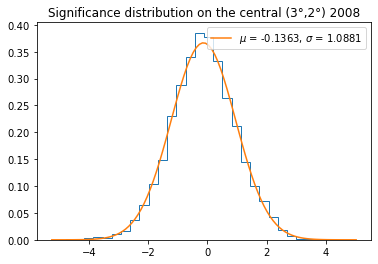

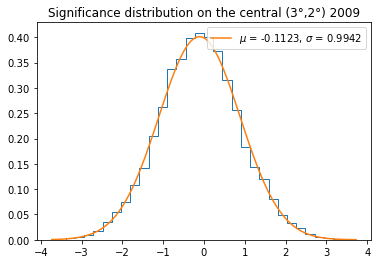

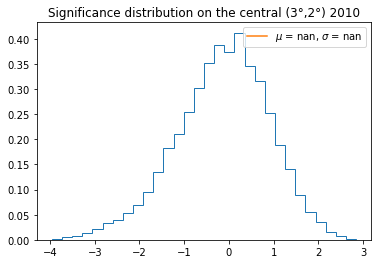

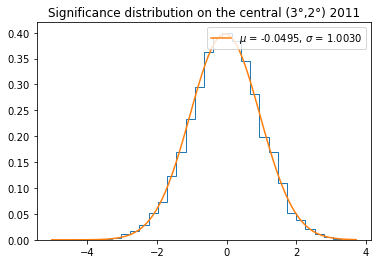

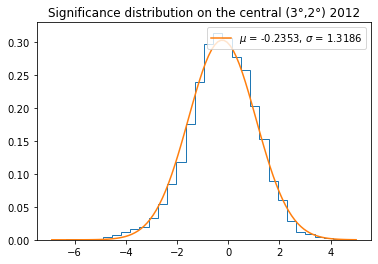

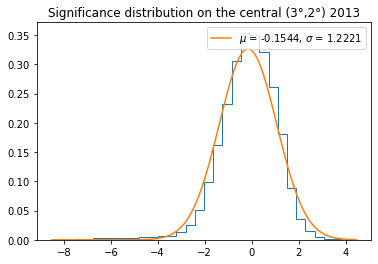

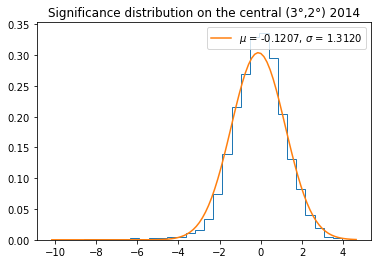

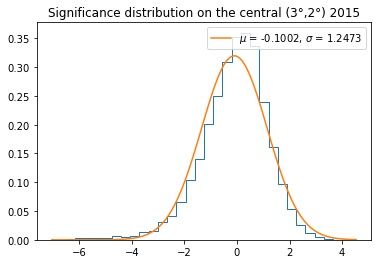

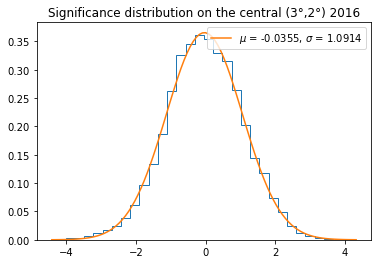

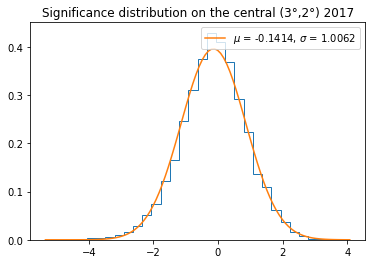

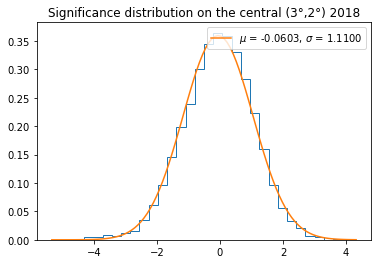

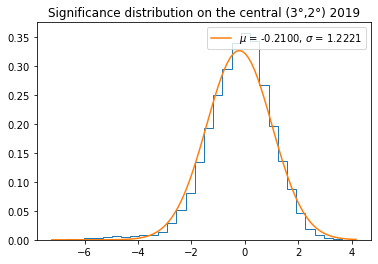

In [124]:
# on veut voir la distribution des significativité dans cette région (par ex)

from scipy.stats import norm

pathh = Path(paths/"significance_distrib")
pathh.mkdir(exist_ok=True)

for year in years:
    plt.figure()
    signidata = lima_significances[year]['significance'].cutout(position=src_pos, width=(3 * u.deg, 2* u.deg)).data
    
    # on masque la région en bas à droite
    mask = fit_mask.reduce_over_axes(func=np.logical_or).cutout(position=src_pos, width=(3 * u.deg, 2 * u.deg)).data

    plt.hist(signidata[mask].flatten(),30, histtype='step', density=True)
    
    mean,std=norm.fit(signidata[mask])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    y = norm.pdf(x, mean, std)
    plt.plot(x, y, label=r'$\mu$ = {0:03.4f}, $\sigma$ = {1:03.4f}'.format(mean,std))
    
    plt.legend(loc=1)
    
    name = "significance_hist"+str(year)+"_hd_full.pdf"
    plt.title("Significance distribution on the central (3°,2°) "+str(year))
    plt.savefig(pathh/name, overwrite=True)

## Time evolution of the fluxes

In [125]:
def CalculateFluxFromModels(year, emin, emax):
    GC_model, G09, DE_model  = mapdataset_dict[year].models
    
    amplitudeGC = results_per_year[year]['value'][3]
    amp_errGC = results_per_year[year]['error'][3]
    amplitudediff = results_per_year[year]['value'][12]
    amp_errdiff = results_per_year[year]['error'][12]

    norm = results_per_year[year]['value'][14]
    norm_err = results_per_year[year]['error'][14]

    if isinstance(emin, u.Quantity):
        #il faut convertir le flux du diffus qui est en sr-1, 
        # donc intégrer sur tout l'angle solide du template (opération inverse de celle effectuée par TamplateSpatialModel)
        
        diffuse_flux = DE_model.spectral_model.integral(emin, emax)#*solid_angle_tot/u.sr  
        GC_flux = GC_model.spectral_model.integral(emin, emax)
        
    if np.isscalar(emin):
        emin = emin*u.TeV
        emax = emax*u.TeV
        diffuse_flux = DE_model.spectral_model.integral(emin, emax)
        GC_flux = GC_model.spectral_model.integral(emin, emax)
    
    return diffuse_flux, GC_flux, amplitudeGC, amp_errGC, amplitudediff, amp_errdiff, norm, norm_err

In [126]:
# Extracting parameters from each years fitted model

emin = 1.0*u.TeV
emax = 10*u.TeV
resGC = []
resdiff = []
ampsGC = []
amp_errsGC = []
ampsdiff = []
amp_errsdiff = []
norms = []
norms_err = []


for year in years:
    dif , GC, amp, amp_err, ampdiff, amp_errdiff, norm, norm_err = CalculateFluxFromModels(year, emin, emax)
    
    resGC.append(GC.value)
    resdiff.append(dif.value)
    ampsGC.append(amp)
    amp_errsGC.append(amp_err)
    ampsdiff.append(ampdiff)
    amp_errsdiff.append(amp_errdiff)
   
    
    norms.append(norm)
    norms_err.append(norm_err)
    
resGC = np.asarray(resGC)
ampsGC = np.asarray(ampsGC)
amp_errsGC = np.asarray(amp_errsGC)
resdiff = np.asarray(resdiff)
ampsdiff = np.asarray(ampsdiff)
amp_errsdiff = np.asarray(amp_errsdiff)
norms = np.asarray(norms)
norms_err = np.asarray(norms_err)

In [127]:
# Errors computation

yerrGC = (resGC/ampsGC)*amp_errsGC
yerrdiff = (resdiff/ampsdiff)*amp_errsdiff



cross_term = []

for k,year in zip(range(len(years)),years):
    term = 2*(cov_per_year[year][0,1]*yerrGC[k]*yerrdiff[k])/(resGC[k]*resdiff[k])
    cross_term.append(term)
      
yerr_rap = (resGC/resdiff)*np.sqrt((yerrGC/resGC)**2 + (yerrdiff/resdiff)**2 - cross_term )

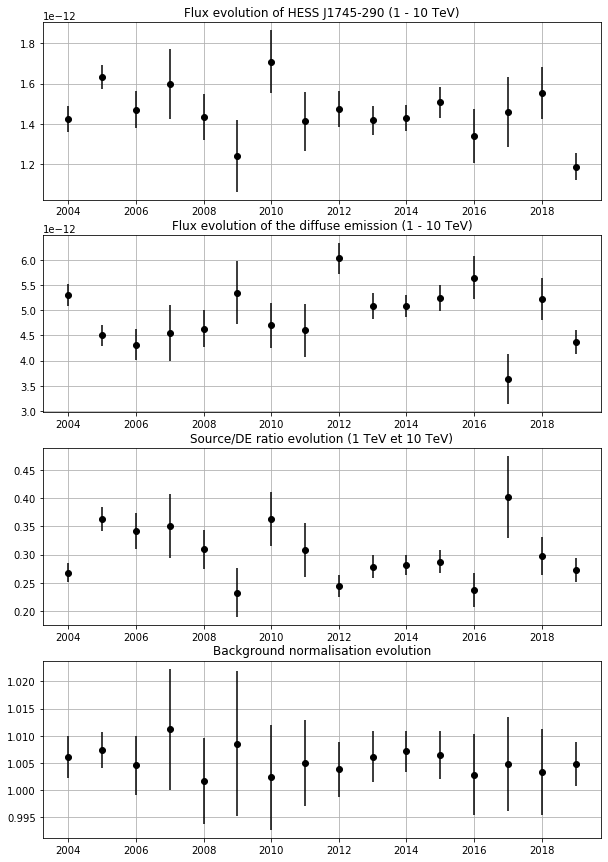

In [129]:
plt.figure(figsize=(10,15))

ax1 = plt.subplot(4,1,1)

plt.errorbar(years , resGC, yerr=yerrGC, fmt='ko')# ax=ax1)
plt.title("Flux evolution of HESS J1745-290 (1 - 10 TeV)")
plt.grid()

ax2 = plt.subplot(4,1,2)
plt.errorbar(years , resdiff, yerr=yerrdiff, fmt='ko')
plt.title("Flux evolution of the diffuse emission (1 - 10 TeV)")
plt.grid()

ax2 = plt.subplot(4,1,3)
plt.errorbar(years , resGC/resdiff, yerr=yerr_rap, fmt='ko')
plt.title("Source/DE ratio evolution (1 TeV et 10 TeV)")
plt.grid()


ax4 = plt.subplot(4,1,4)
plt.errorbar(years , norms, yerr=norms_err, fmt='ko')# ax=ax1)
plt.title("Background normalisation evolution")
plt.grid()

plt.savefig(path/"GCDEflux_evolution_04_19_hd_full.pdf")

## Fitting a time evolution model

In [130]:
import scipy.stats as stats

from astropy.modeling import models, fitting

from scipy.stats import chisquare, chi2

# chi2 non réduit
def chisq(obs, exp, error):
    chisq = 0
    for i in range(len(obs)):
        chisq = chisq + ((obs[i]-exp)**2)/(error[i]**2)
    return chisq

# chi2 réduit
def chisqr(obs, exp, error):
    chisqr = 0
    for i in range(len(obs)):
        chisqr = chisqr + ((obs[i]-exp)**2)/(error[i]**2)
    return chisqr/(len(obs) -1)

def pval(obs, exp, error):
    chisq = 0
    for i in range(len(obs)):
        chisq = chisq + ((obs[i]-exp)**2)/(error[i]**2)
    nddl = len(obs)
    pval = 1 - chi2.cdf(chisq, nddl)
    return pval

### Evolution for the central source

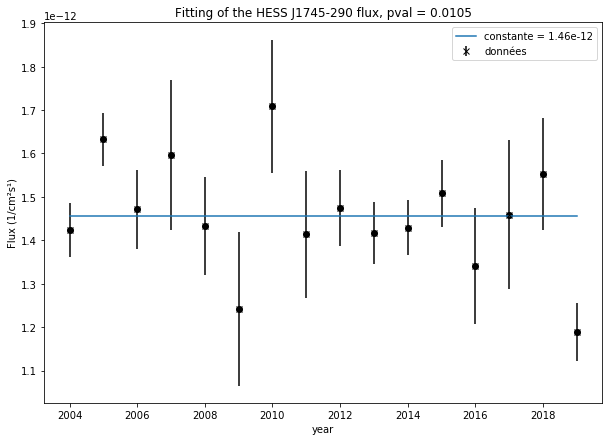

In [131]:
x = years
y = resGC
y_uncs = yerrGC


# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1e-12)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = y
A2 = t(2004)
err_bars = y_uncs
#chi2, pval = stats.chisquare(y, A2)
chi2r = chisqr(A1, A2, err_bars)

pv = pval(A1, A2, err_bars)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14)) )
plt.xlabel('year')
plt.ylabel('Flux (1/cm²s¹)')
plt.legend(loc=1)
plt.title("Fitting of the HESS J1745-290 flux, pval = {0:03.4f}".format(pv))
plt.savefig(path/"fit_flux_SgrAstar_04_19_hd_full.pdf")

### Evolution of the diffuse emission

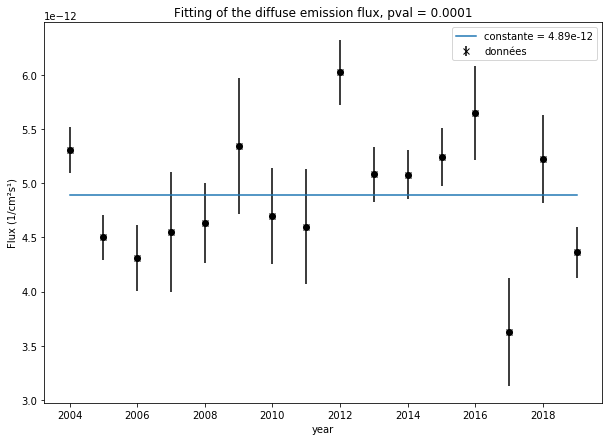

In [132]:
x = years
y = resdiff
y_uncs = yerrdiff


# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1e-10)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y)#, weights=1.0/y_uncs)

A1 = y
A2 = t(2004)
err_bars = y_uncs
#chi2, pval = stats.chisquare(A1, A2)
chi2r = chisqr(A1, A2, err_bars)

pv = pval(A1, A2, err_bars)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14)) )
plt.xlabel('year')
plt.ylabel('Flux (1/cm²s¹)')
plt.legend(loc=1)
plt.title("Fitting of the diffuse emission flux, pval = {0:03.4f}".format(pv))
plt.savefig(path/"fit_flux_DE_04_19_hd_full.pdf")

### Evolution of the ratio

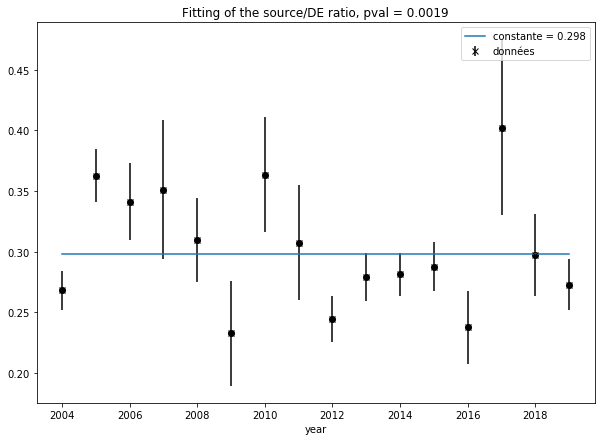

In [134]:
x = years
y = resGC/resdiff


# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(0.6)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y, weights=1.0/y_uncs)


A1 = y
A2 = t(2004)
err_bars = yerr_rap
pv = pval(A1, A2, err_bars)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=yerr_rap, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 3)) )
plt.xlabel('year')
plt.ylabel('')
plt.legend(loc=1)

plt.title("Fitting of the source/DE ratio, pval = {0:03.4f}".format(pv))
plt.savefig(path/"fit_flux_GCsurDE_04_19_hd_full.pdf")